# Bias Amplification by Inductive Transfer Learning

This notebook guides you through the process of bias amplification by inductive transfer learning. This demonstration uses chest X-ray images from the Medical Imaging & Data Resource Center (MIDRC) Open-A1 data set as the example, and provides you with the instruction on how to train and deploy the model, as well as visualize the amplified bias.
The inductive transfer learning approach establishes a two-step transfer learning process to amplify bias. In the first step, the AI model is trained to classify patients according to a subgroup attribute (e.g., patient sex). In the second step, the model is fine-tuned to the target clinical task. Additional control over the degree to which bias is promoted using this process can be obtained by altering the number of layers frozen during the second training step.

***Note: before you can run either of the example notebooks, you must download and preprocess the data.*** The example uses MIDRC Open-A1 chest X-ray dataset ([MIDRC official website](https://data.midrc.org/)), which can be accessed and downloaded by following the instruction ([link for download instruction](https://data.midrc.org/dashboard/Public/documentation/Gen3_MIDRC_GetStarted.pdf)). The data preprocessing can be completed using the provided [```data_preprocessing.sh```](data_preprocessing.sh) script; *before running this script, open it to edit the necessary file path variables (indicated at the top of the file)*.

## Sections

- [1. Data Partition](#data_partition)\
Partition data into training, validation and test sets.
- [2. Model Training](#model_training)\
Train bias amplification models.
    - [2.1 First Step Training](#model_training_1)\
    Train the model to classify subgroup attributes.
    - [2.2 Second Step Training](#model_training_2)\
    Fine-tune the model to preform clinical tasks.
    - [2.3 Baseline Model Training](#model_training_b)\
    Train the baseline model without bias amplification.
- [3. Model Inference](#model_inference)\
Deploy models on the independent test set.
- [4. Bias Visualization](#bias_visualization)\
Calculate metric and visualize model bias.

<a id='data_partition'></a>
## 1. Data Partition

After data are converted to *.jpeg* files, they needed to be properly partitioned into training, validation and testing sets. In this experiment, all the data sets are equally stratified by patient sex (male and female), race (white and black) and COVID status (positive and negative). For each patient, only 1 image is selected (only CR images are used). To accelerate the whole experiment process, only 25% of the image data is used in this example. 

In [2]:
# # data partitioning
# EDIT. folder to save partitioning csv lists and conduct experiments
jpeg_save_dir = "data/open_A1_jpegs"
main_dir = "inductive_transfer_learning"
conversion_file = jpeg_save_dir + "/conversion_table.json"
%run ../src/utils/data_partitions.py \
    --input_list "data/open_A1_summary.json" \
    --conversion_file "{conversion_file}" \
    --test_size 0.3 \
    --validation_size 0.2 \
    --save_dir "{main_dir}" \
    --max_img_per_patient 1 \
    --tasks 'M' 'F' 'White' 'Black' 'Yes' 'No' \
    --patient_img_selection_mode "random" \
    --random_seed 2 \
    --subsample_rate 0.25

Beginning bootstrapping

Number of patients/subgroup in input summary:
| subgroup       |   count |
|:---------------|--------:|
| F-Black-No-CR  |     676 |
| F-Black-Yes-CR |    1913 |
| F-White-No-CR  |    2004 |
| F-White-Yes-CR |    1250 |
| M-Black-No-CR  |     658 |
| M-Black-Yes-CR |    1683 |
| M-White-No-CR  |    1863 |
| M-White-Yes-CR |    1333 |

By patient summary of data partition

| subgroup       |   independent_test |   train |   validation |   All |
|:---------------|-------------------:|--------:|-------------:|------:|
| F-Black-No-CR  |                 49 |      82 |           33 |   164 |
| F-Black-Yes-CR |                 49 |      82 |           33 |   164 |
| F-White-No-CR  |                 49 |      82 |           33 |   164 |
| F-White-Yes-CR |                 49 |      82 |           33 |   164 |
| M-Black-No-CR  |                 49 |      82 |           33 |   164 |
| M-Black-Yes-CR |                 49 |      82 |           33 |   164 |
| M-White-No-CR 

<a id='model_training'></a>
## 2. Model Training

After data partitioning is done, the following section will show you how to train the model to amplify the bias between subgroups. As an example, this demonstration amplifies the bias between subgroups defined by patient sex.

<a id='model_training_1'></a>
### 2.1 First step training

To amplify bias by inductive transfer learning, the first step is to train the model to classify subgroup attribute (e.g., patient sex). You can run the following cell to train two separate sex classification models:
 - Model where "M" (male) is associated with model classification of “1” and will be associated with the COVID-positive class
 - Model where "F" (female) is associated with model classification of “1” and will be associated with the COVID-positive class

In this demonstration we use *ResNet-18* as the example network architecture, and pre-trained weights trained from a contrastive self-supervised learning (CSL) approach and data from the CheXpert data set. This weight file can be found under *example/* directory.

In [3]:
# first step training
task_list = ["M", "F"]
for task in task_list:
    %run ../src/utils/model_train.py --input_train_file "{main_dir}/train.csv" \
                                     --validation_file "{main_dir}/validation.csv" \
                                     --output_base_dir "{main_dir}/{task}" \
                                     --log_path "{main_dir}/{task}/run_log.log" \
                                     --custom_checkpoint_file "csl.pth.tar" \
                                     --optimizer "adam" \
                                     --gpu_id 0 \
                                     --save_every_N_epochs 3 \
                                     --random_state 0 \
                                     --pretrained_weights True \
                                     --train_task "{task}"

Start experiment...
Using custom pretrained checkpoint file
Full fine tuning selected
Training for task: M


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/M/pytorch_last_epoch_model.onnx
END.
Start experiment...
Using custom pretrained checkpoint file
Full fine tuning selected
Training for task: F


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/F/pytorch_last_epoch_model.onnx
END.


<a id='model_training_2'></a>
### 2.2 Second step training

The second step is to fine-tune the model from step 1 to perform the target clinical task. During this step, the same training/validation sets are used. By running the following cell, you can fine-tune these two resulted models to predict COVID status, with different number of model layers being frozen. In this example, two different numbers of frozen layers are shown for both pre-trained models. 

In [4]:
# second step training
frozen_layers = [1, 9]
for task in task_list:
    for n in frozen_layers:
        %run ../src/utils/model_train.py --input_train_file "{main_dir}/train.csv" \
                                         --validation_file "{main_dir}/validation.csv" \
                                         --output_base_dir "{main_dir}/{task}_{n}_frozen_layer/" \
                                         --log_path "{main_dir}/{task}_{n}_frozen_layer/run_log.log" \
                                         --custom_checkpoint_file "{main_dir}/{task}/checkpoint__last.pth.tar" \
                                         --fine_tuning "partial" \
                                         --optimizer "adam" \
                                         --gpu_id 0 \
                                         --save_every_N_epochs 3 \
                                         --random_state 0 \
                                         --pretrained_weights True \
                                         --freeze_up_to {n}

Start experiment...
Using custom pretrained checkpoint file
Fine tuning with first 1 layers frozen
Training for task: Yes


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/M_1_frozen_layer/pytorch_last_epoch_model.onnx
END.
Start experiment...
Using custom pretrained checkpoint file
Fine tuning with first 9 layers frozen
Training for task: Yes


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/M_9_frozen_layer/pytorch_last_epoch_model.onnx
END.
Start experiment...
Using custom pretrained checkpoint file
Fine tuning with first 1 layers frozen
Training for task: Yes


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/F_1_frozen_layer/pytorch_last_epoch_model.onnx
END.
Start experiment...
Using custom pretrained checkpoint file
Fine tuning with first 9 layers frozen
Training for task: Yes


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/F_9_frozen_layer/pytorch_last_epoch_model.onnx
END.


<a id='model_training_b'></a>
### 2.3 Baseline model training

To show the degree to which bias is amplified by this approach, a baseline model is required to present baseline bias. You can run the following cell to train the baseline. To make fair comparison, the baseline uses the same model architecture and pre-trained weights (from CSL approach), as well as the same training/validation sets. However, it will skip the first step training, and directly train to perform COVID status prediction.

In [7]:
# baseline training
%run ../src/utils/model_train.py     --input_train_file "{main_dir}/train.csv" \
                                     --validation_file "{main_dir}/validation.csv" \
                                     --output_base_dir "{main_dir}/baseline" \
                                     --log_path "{main_dir}/baseline/run_log.log" \
                                     --custom_checkpoint_file "csl.pth.tar" \
                                     --optimizer "adam" \
                                     --gpu_id 0 \
                                     --save_every_N_epochs 3 \
                                     --random_state 2 \
                                     --pretrained_weights True

Start experiment...
Using custom pretrained checkpoint file
Full fine tuning selected
Training for task: Yes


IntProgress(value=0, description='Training progress:', max=10, style=ProgressStyle(bar_color='#007CBA', descri…

IntProgress(value=0, description='Current epoch:', max=14, style=ProgressStyle(bar_color='#64b5de', descriptio…

GridBox(children=(VBox(children=(Label(value='EPOCH', style=LabelStyle(font_weight='bold')),), layout=Layout(b…

Final epoch model saved to: inductive_transfer_learning/baseline/pytorch_last_epoch_model.onnx
END.


<a id='model_inference'></a>
## 3. Model Inference

After model training is done, you can deploy the models on the independent testing set by running the following cell. The inference code will save prediction scores as *results__.tsv* files under the same directory.

In [8]:
# experiment model inference
for task in task_list:
    for n in frozen_layers:
        %run ../src/utils/model_inference.py \
            --input_list_file "{main_dir}/independent_test.csv" \
            --weight_file "{main_dir}/{task}_{n}_frozen_layer/pytorch_last_epoch_model.onnx" \
            --gpu_id 0 \
            --log_path "{main_dir}/{task}_{n}_frozen_layer/inference_log.log"
# baseline model inference
%run ../src/utils/model_inference.py \
            --input_list_file "{main_dir}/independent_test.csv" \
            --weight_file "{main_dir}/baseline/pytorch_last_epoch_model.onnx" \
            --gpu_id 0 \
            --log_path "{main_dir}/baseline/inference_log.log"

Start inference...
 There are 392 test samples in the list
 AUROC = 0.6560
 Time taken: 44.80 seconds
END.
Start inference...
 There are 392 test samples in the list
 AUROC = 0.6442
 Time taken: 36.86 seconds
END.
Start inference...
 There are 392 test samples in the list
 AUROC = 0.6397
 Time taken: 36.53 seconds
END.
Start inference...
 There are 392 test samples in the list
 AUROC = 0.6398
 Time taken: 37.99 seconds
END.
Start inference...
 There are 392 test samples in the list
 AUROC = 0.6612
 Time taken: 37.97 seconds
END.


<a id='bias_visualization'></a>
## 6. Bias Visualization

After inference, you can analyze the model bias by running the following code. The analysis code here will calculate the subgroup **predicted prevalence** and **AUROC** , and plot them with respect to different number of frozen layers during second step transfer learning.


Start subgroup bias measurements


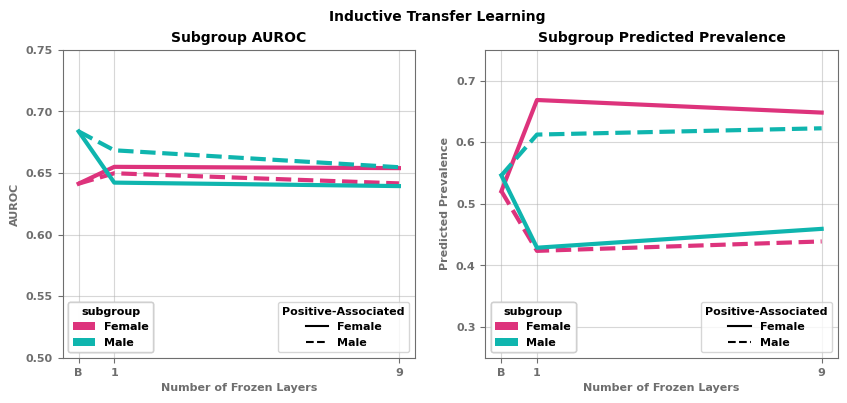


Done



In [9]:
# bias measurements and visualization
%run ../src/utils/bias_analysis.py \
    --main_dir "{main_dir}" \
    --exp_list "baseline" "M_1_frozen_layer" "M_9_frozen_layer" "F_1_frozen_layer" "F_9_frozen_layer" \
    --amplification_type "inductive transfer learning" \
    --testing_result_file "results__.tsv" \
    --testing_info_file "{main_dir}/independent_test.csv" \
    --test_subgroup "sex" 